In [1]:

CUDA_LAUNCH_BLOCKING=1
import torch
import torch.nn as nn
import numpy as np 


import random

import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:6")

H = torch.load("./test/original_weights.pt")["H"].to(device).float()
weights = torch.load("./test/original_weights.pt")["weights"].to(device).float()    

# weights = weights[:,:-2]
# print(weights.shape)

In [3]:
torch.random.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
def create_mask(data:list,percent_top):
    """
    data: list of torch.tensor of shape (n)
    percent_top: float, the percentage of the top values to keep
    """
    mask = torch.ones(data[0].shape, dtype = torch.bool, device = data[0].device)

    datas_sorted = [torch.sort(data[i], descending = True)[0] for i in range(len(data))]
    i = 0
    big_i = 0
    # print(mask.sum(), (100-percent_top)/100 * mask.numel())
    # raise ValueError("The mask is not sparse enough")
    while mask.sum() > (100-percent_top)/100 * mask.numel():
        # print(mask.sum())
        mask &= data[i%len(data)] < datas_sorted[i][big_i]
        i += 1
        i = i % len(data)
        if i == 0:
            big_i += 1
        # if i==0:
        #     raise ValueError("The mask is not sparse enough")
    # threshold = torch.quantile(data, 1-percent_top/100)
    return mask

d = 1
percent_dense_rowise = 1
percent_dense_columnwise = 1


# row_mask = create_mask([torch.norm(weights, dim = 1)], percent_dense_rowise)
# column_mask = create_mask([torch.norm(weights, dim = 0),torch.norm(H, dim = 0)], percent_dense_columnwise)

# print("row_mask.sum() = ", row_mask.sum())
# print("column_mask.sum() = ", column_mask.sum())


def mask_round(mask, d):

    while mask.sum() % d != 0:
        mask[torch.randint(0, mask.shape[0], (1,))] = False
        print(mask.sum())

    return mask

if percent_dense_columnwise == 0:
    column_mask = torch.ones(weights.shape[1], dtype = torch.bool, device = weights.device)
else:
    column_mask = create_mask([torch.norm(weights, dim = 0)], percent_dense_columnwise)
    column_mask = mask_round(column_mask, d)
    
if percent_dense_rowise == 0:
    
    row_mask = torch.ones(weights.shape[0], dtype = torch.bool, device = weights.device)    
else:
    row_mask = create_mask([torch.norm(weights, dim = 1)], percent_dense_rowise)
    row_mask = mask_round(row_mask, d)


mask = row_mask.unsqueeze(1) & column_mask.unsqueeze(0)

print("row_mask.sum() = ", row_mask.sum())
print("column_mask.sum() = ", column_mask.sum())

row_mask.sum() =  tensor(4055, device='cuda:6')
column_mask.sum() =  tensor(4055, device='cuda:6')


In [4]:
weights_adjusted = weights[row_mask,:][:, column_mask]
# print()
weights_norms_rowwise = torch.norm(weights_adjusted, dim = 0)
weights_norms_rowwise[torch.isclose(weights_norms_rowwise, torch.zeros_like(weights_norms_rowwise))] = 1
weights_normalized = weights_adjusted / weights_norms_rowwise.unsqueeze(0)
# weights_norms_columnwise = torch.norm(weights_normalized, dim = 1)
# weights_norms_columnwise[torch.isclose(weights_norms_columnwise, torch.zeros_like(weights_norms_columnwise))] = 1
# weights_normalized = weights_normalized / weights_norms_columnwise.unsqueeze(1)

In [5]:
weights_normalized

tensor([[-0.0039, -0.0158,  0.0058,  ...,  0.0090, -0.0031, -0.0219],
        [-0.0012, -0.0053,  0.0069,  ...,  0.0074,  0.0025, -0.0062],
        [-0.0002,  0.0073, -0.0051,  ..., -0.0042, -0.0043,  0.0087],
        ...,
        [-0.0044, -0.0032,  0.0212,  ..., -0.0026, -0.0087,  0.0141],
        [-0.0043, -0.0112, -0.0089,  ..., -0.0101, -0.0087, -0.0061],
        [ 0.0075,  0.0062,  0.0133,  ...,  0.0174, -0.0199, -0.0213]],
       device='cuda:6')

In [8]:
#do a svd decomposition
U, S, V = torch.svd(weights_normalized)

k = 512

A = (U[:, :k] @ torch.sqrt(torch.diag(S[:k]))).requires_grad_(True)
B = (torch.sqrt(torch.diag(S[:k])) @ V[:, :k].t()).requires_grad_(True)
print(A.shape,A.numel())
lora_overhead = 16*(A.numel() + B.numel())/(weights.numel())
sparse_overhead = 16*(torch.sum(~mask).item())/(weights.numel())
total_bits = 16*(A.numel() + B.numel() + torch.sum(~mask).item())
print("total_bits = ", total_bits, "bits per weight = ", total_bits/weights.numel(),
        "lora_overhead = ", lora_overhead, "sparse_overhead = ", sparse_overhead)

n_iters = 1000
lr = 5e-2
grad_clip = 1e-1
lr_multiple = 0.9
prev_H_error = 1e10
losses = []

for i in tqdm.tqdm(range(n_iters)):

    weights_reconstructed = torch.zeros_like(weights)
    weights_reconstructed[mask] = ((A @ B) * weights_norms_rowwise.unsqueeze(0) #* weights_norms_columnwise.unsqueeze(1)
                                   ).flatten()
    weights_reconstructed[~mask] = weights[~mask]

    diff = weights - weights_reconstructed

    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)
    if H_error < 1e-5:
        break
    if i % 50 == 0:
        print("average_error = ", average_error.item(), "H_error = ", H_error.item())
    H_error.backward()
    losses.append(H_error.item())

    if H_error > prev_H_error:
        lr *= lr_multiple
    prev_H_error = H_error.item()
    with torch.no_grad():
        if i % 1 == 0:
            #update A
            A.grad = A.grad.clamp(-grad_clip, grad_clip)
            A -= lr * A.grad
            A.grad.zero_()

        # else:
            #update B
            B.grad = B.grad.clamp(-grad_clip, grad_clip)
            B -= lr * B.grad
            B.grad.zero_()

torch.Size([4055, 512]) 2076160
total_bits =  71784176 bits per weight =  4.278670310974121 lora_overhead =  3.9599609375 sparse_overhead =  0.3187093734741211


  0%|          | 5/1000 [00:00<00:23, 41.66it/s]

average_error =  0.16381524503231049 H_error =  0.6523004770278931


  5%|▌         | 52/1000 [00:02<00:52, 17.97it/s]

average_error =  0.1645875871181488 H_error =  0.2989295721054077


 10%|█         | 104/1000 [00:05<00:36, 24.85it/s]

average_error =  0.1650630086660385 H_error =  0.26863646507263184


 16%|█▌        | 155/1000 [00:07<00:28, 29.56it/s]

average_error =  0.16543282568454742 H_error =  0.2534675896167755


 20%|██        | 203/1000 [00:09<00:48, 16.31it/s]

average_error =  0.16573594510555267 H_error =  0.2436908632516861


 26%|██▌       | 257/1000 [00:12<00:22, 32.44it/s]

average_error =  0.165995255112648 H_error =  0.23657332360744476


 30%|███       | 301/1000 [00:14<00:37, 18.88it/s]

average_error =  0.16622430086135864 H_error =  0.23101510107517242


 36%|███▌      | 357/1000 [00:17<00:21, 29.84it/s]

average_error =  0.1664314568042755 H_error =  0.22647541761398315


 40%|████      | 402/1000 [00:19<00:33, 18.07it/s]

average_error =  0.16662225127220154 H_error =  0.22265151143074036


 46%|████▌     | 456/1000 [00:22<00:23, 23.15it/s]

average_error =  0.1668003499507904 H_error =  0.2193576991558075


 50%|█████     | 505/1000 [00:24<00:16, 29.48it/s]

average_error =  0.16696839034557343 H_error =  0.2164720892906189


 55%|█████▌    | 553/1000 [00:26<00:26, 17.17it/s]

average_error =  0.16712802648544312 H_error =  0.21391038596630096


 60%|██████    | 605/1000 [00:29<00:16, 23.24it/s]

average_error =  0.16728055477142334 H_error =  0.21161188185214996


 65%|██████▌   | 653/1000 [00:31<00:14, 23.72it/s]

average_error =  0.16742698848247528 H_error =  0.20953133702278137


 70%|███████   | 702/1000 [00:34<00:18, 16.08it/s]

average_error =  0.16756804287433624 H_error =  0.20763421058654785


 75%|███████▌  | 752/1000 [00:36<00:15, 16.03it/s]

average_error =  0.1677042841911316 H_error =  0.20589342713356018


 80%|████████  | 802/1000 [00:40<00:12, 15.38it/s]

average_error =  0.16783617436885834 H_error =  0.20428742468357086


 85%|████████▌ | 852/1000 [00:43<00:09, 15.11it/s]

average_error =  0.1679641455411911 H_error =  0.2027987539768219


 90%|█████████ | 902/1000 [00:46<00:06, 15.05it/s]

average_error =  0.16808855533599854 H_error =  0.20141306519508362


 95%|█████████▌| 952/1000 [00:49<00:03, 14.94it/s]

average_error =  0.16820964217185974 H_error =  0.20011842250823975


100%|██████████| 1000/1000 [00:53<00:00, 18.79it/s]


In [55]:
X = torch.rand(100,weights.shape[1], device = device)

Y_true = torch.nn.functional.linear(X, weights)

Y_reconstructed = torch.nn.functional.linear(X, weights_reconstructed)

Y_attempt = torch.zeros_like(Y_reconstructed)
Y_attempt[...,row_mask] = torch.nn.functional.linear(torch.nn.functional.linear(X[..., column_mask]* weights_norms_rowwise.unsqueeze(0), B), A)
Y_attempt[...,row_mask] += torch.nn.functional.linear(X[..., ~column_mask], weights[row_mask][...,~column_mask])
Y_attempt[...,~row_mask] = torch.nn.functional.linear(X, weights[~row_mask])

In [56]:
torch.max(torch.abs(Y_attempt - Y_reconstructed))

tensor(0.0005, device='cuda:6', grad_fn=<MaxBackward1>)

In [52]:
weights[(~row_mask.unsqueeze(1)) | (~column_mask.unsqueeze(0))]
        
        column_mask]

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [21], [4055]

In [30]:
weights_norms_rowwise.shape

torch.Size([4055])

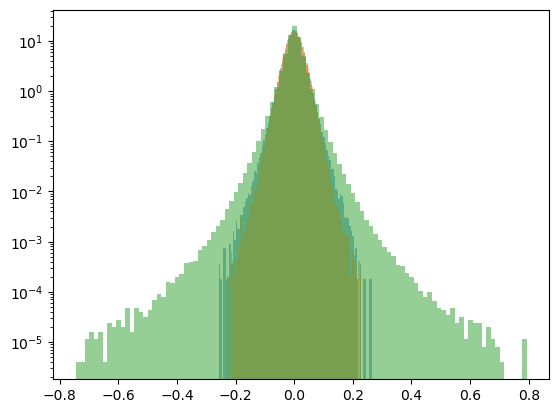

In [98]:
plt.hist(A.flatten().detach().cpu().numpy(), bins = 100, density=True, alpha = 0.5)
plt.hist(B.flatten().detach().cpu().numpy(), bins = 100, density=True, alpha = 0.5)
plt.hist(weights.flatten().detach().cpu().numpy(), bins = 100, density=True, alpha = 0.5)
plt.yscale("log")

In [7]:
import torch
import torch.nn as nn 

device = torch.device("cuda:6")

class test(nn.Module):
    def __init__(self):
        super().__init__()
        self.A = nn.Parameter(torch.randn(10,10, device = device))
        self.register_buffer("mask", torch.randn(10,10, device = device) > 0)
        self.register_buffer("mask2", torch.randint(0,2,(10,10), device = device))
        
t = test()
print(t.mask2)
t.to(torch.half)
t.to("cpu") 
print(t.mask2)
        
    

tensor([[1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 1],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [1, 0, 0, 1, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1, 0, 1, 1, 0, 0]], device='cuda:6')
tensor([[1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 0, 1, 0, 1, 0, 1],
        [1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [1, 0, 0, 1, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1, 0, 1, 1, 0, 0]])


In [10]:
a = torch.zeros(100,25)
indexs = torch.randint(0,10,(100,10))
a[indexs].shape

torch.Size([100, 10, 25])

In [100]:
def stochastic_round(X,codebook):
    """
    X: torch.tensor of shape (n)
    codebook: torch.tensor of shape (m)
    """

    distances = torch.abs(X.reshape(list(X.shape) + [1]) - codebook.reshape([1]*len(X.shape) + list(codebook.shape)))
    #for each one select the smallest 2 indices
    distance, indices = torch.topk(distances, 2, dim = -1, largest = False)
    # print(distance[0])
    #randomly choose based on the distance
    random_choice = torch.rand_like(X)

    probabilities = distance/(distance.sum(-1, keepdim = True) + 1e-10)
    # print(probabilities[0])
    # print(probabilities.shape, random_choice.shape)
    # print((random_choice < probabilities[..., 0])[0])
    return torch.where(random_choice < probabilities[..., 0],  indices[..., 1],indices[..., 0])

In [111]:
n_bits =  4
# A = A.detach().requires_grad_(False)
A_codebook = torch.linspace(A.min(), A.max(), 2**n_bits).to(device)
errrors = torch.abs(A.unsqueeze(-1) - A_codebook.unsqueeze(0).unsqueeze(0))
# assignments_A = stochastic_round(A, A_codebook)
# raise ValueError("stop")

assignments_A = torch.argmin(torch.abs(A.unsqueeze(-1) - A_codebook.unsqueeze(0).unsqueeze(0)), dim = -1)
A_codebook = A_codebook.requires_grad_(True)

# B = B.detach().requires_grad_(False)
B_codebook = torch.linspace(B.min(), B.max(), 2**n_bits).to(device)
# assignments_B = stochastic_round(B, B_codebook)
assignments_B = torch.argmin(torch.abs(B.unsqueeze(-1) - B_codebook.unsqueeze(0).unsqueeze(0)), dim = -1)

quantized_low_rank_bits = (n_bits*assignments_A.numel() + n_bits*assignments_B.numel())
total_bits = 16*(torch.sum(~mask).item()) + 16*(A_codebook.numel() + B_codebook.numel()) + quantized_low_rank_bits

print("quantized_low_rank_bits = ", quantized_low_rank_bits/weights.numel(), "bits per weight = ", (total_bits)
                                                                                                    /weights.numel())

# raise ValueError("stop")
B_codebook = B_codebook.requires_grad_(True)

n_iters = 1000
lr = 1e-1
grad_clip = 1e-1
lr_multiple = 0.9
prev_H_error = 1e10
patience = 100
patience_used = 0
eps = 1e-3

for i in tqdm.tqdm(range(n_iters)):
    
    A_quantized = A_codebook[assignments_A]
    B_quantized = B_codebook[assignments_B]
    # print("A_quantized = ", A_quantized.shape, "A= ", A.shape)
    # print("B_quantized = ", B_quantized.shape, "B= ", B.shape)
    # raise ValueError("stop")

    weights_reconstructed = torch.zeros_like(weights)
    weights_reconstructed[mask] = ((A_quantized @ B_quantized) * weights_norms_rowwise.unsqueeze(0) * weights_norms_columnwise.unsqueeze(1)
                                   ).flatten()
    weights_reconstructed[~mask] = weights[~mask]

    diff = weights - weights_reconstructed

    average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

    H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)
    # print("average_error = ", average_error.item(), "H_error = ", H_error.item())
    # raise ValueError("stop")
    if H_error < 1e-5:
        break
    if i % 50 == 0:
        print("average_error = ", average_error.item(), "H_error = ", H_error.item())
    H_error.backward()
    losses.append(H_error.item())

    if prev_H_error - H_error < eps:
        lr *= lr_multiple
        # print("lr = ", lr)
        patience_used += 1
        if patience_used > patience:
            break
    else:
        patience_used = 0
        prev_H_error = H_error.item()
    with torch.no_grad():
        if i % 1 == 0:
            #update A
            A_codebook.grad = A_codebook.grad.clamp(-grad_clip, grad_clip)
            A_codebook -= lr * A_codebook.grad
            A_codebook.grad.zero_()

        # else:
            #update B
            B_codebook.grad = B_codebook.grad.clamp(-grad_clip, grad_clip)
            B_codebook -= lr * B_codebook.grad
            B_codebook.grad.zero_()
    if i % 10 ==  9:
        with torch.no_grad():
            assignments_A = torch.argmin(torch.abs(A.unsqueeze(-1) - A_codebook.unsqueeze(0).unsqueeze(0)), dim = -1) #stochastic_round(A, A_codebook)
            assignments_B = torch.argmin(torch.abs(B.unsqueeze(-1) - B_codebook.unsqueeze(0).unsqueeze(0)), dim = -1) #stochastic_round(B, B_codebook)

print("average_error = ", average_error.item(), "H_error = ", H_error.item())

quantized_low_rank_bits =  0.49871826171875 bits per weight =  0.580780029296875


  0%|          | 1/1000 [00:00<02:13,  7.46it/s]

average_error =  0.5106793642044067 H_error =  23.37791633605957


  5%|▌         | 51/1000 [00:04<01:16, 12.46it/s]

average_error =  0.39892807602882385 H_error =  10.105695724487305


 10%|█         | 101/1000 [00:08<01:12, 12.47it/s]

average_error =  0.3982369601726532 H_error =  10.00516128540039


 15%|█▍        | 148/1000 [00:12<01:10, 12.07it/s]

average_error =  0.3982584476470947 H_error =  10.002592086791992


In [102]:
H_error

tensor(7.9834, device='cuda:6', grad_fn=<ViewBackward0>)

In [26]:
diff = weights - weights_reconstructed

average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

print("average_error = ", average_error, "H_error = ", H_error)

average_error =  tensor(0.5148, device='cuda:6') H_error =  tensor(3955.0728, device='cuda:6')
